<a href="https://colab.research.google.com/github/drscook/m5364_23sp_data_science1/blob/main/pipelines_AirBNB_ipynb_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Setup & Background

In [ ]:
# upgrade to most recent versions (Pandas 2.0 released on April 6, 2023)
# run once at start of session
# ignore any "pip dependency" errors
! pip install -q --upgrade numpy pandas scikit-learn matplotlib shap jupyter-autotime
# restart kernel so upgrade takes effect
from IPython import get_ipython
get_ipython().kernel.do_shutdown(True)

#Preprocessing

In [1]:
%reload_ext autotime
import os, pathlib, joblib, contextlib, google.colab, numpy as np, pandas as pd, sklearn, shap, matplotlib.pyplot as plt, missingno as msno
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.impute import KNNImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, RocCurveDisplay

sklearn.set_config(transform_output = "pandas")
def disp(X):
    display(pd.DataFrame(X).head(3))

# set random seed for reproducible results
seed = 42

# mount drive and set path
root = pathlib.Path("/content/drive")
google.colab.drive.mount(str(root))
path = root / "MyDrive/CEE_workshop"
path.mkdir(exist_ok=True)

# read or fetch data
file = path / "airbnb.parquet"
try:
    df = pd.read_parquet(file)
    print(f'using data saved at {file}')
except:
    print(f'downloading data')
    airbnb = fetch_openml(data_id=43819, parser="auto")
    df = airbnb.data
    print(f'saving data to {file}')
    df.to_parquet(file, index=False)
df = df.convert_dtypes().set_index('id')

for col in df.columns:
    try:
        df[col] = df[col].str.lower()
    except AttributeError:
        pass
df['price'] = df['price'].str.replace(',','').astype(float)
df['pets_ok'] = ~df['house_rules'].str.contains('no pets')
df['smoking_ok'] = ~df['house_rules'].str.contains('smok')

target = 'review_scores_rating'
features         = ['price', 'bedrooms', 'bathrooms', 'cleaning_fee', 'pets_ok', 'smoking_ok', 'amenities_dict', 'neighbourhood_cleansed']
numeric_features = ['price', 'bedrooms', 'bathrooms', 'cleaning_fee', 'pets_ok', 'smoking_ok']
mask = df[target].notnull()
F = df.loc[mask, features]

A = df['amenities_dict'].str.split(', ', expand=True)
amenities_features = A.columns = [x.split(':')[0].strip("'") for x in A.iloc[0]]
A.columns = amenities_features
def amentity_offered(x):
    return (x.str[-1] == '1').astype('boolean')
A = A.apply(amentity_offered)

enc = OneHotEncoder(sparse_output=False)
N = enc.fit_transform(df[['neighbourhood_cleansed']]).astype('boolean')
neighorhoods_features = N.columns.str[23:]
N.columns = neighorhoods_features

X = F.join(N).join(A).drop(columns=['amenities_dict', 'neighbourhood_cleansed'])
disp(X)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
using data saved at /content/drive/MyDrive/CEE_workshop/airbnb.parquet


,price,bedrooms,bathrooms,cleaning_fee,pets_ok,smoking_ok,allston,back bay,bay village,beacon hill,...,bath towel,toilet paper,safe,bedroom comforts,bathroom essentials,game room,luggage storage,front desk,self parking,concierge
id,,,,,,,,,,,,,,,,,,,,,
3781,125.0,1,1.0,75,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
5506,145.0,1,1.0,60,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
6695,169.0,1,1.0,80,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


Now we can start building a model. I decided not to use neighborhoods after all because there are a lot of them (25) and I'm worried about the [Curse of Dimensionality](https://en.wikipedia.org/wiki/Curse_of_dimensionality). I have the same concern about amenities, so we'll use Principal Components Analysis to reduce their dimension. But I don't think that will work for neighborhoods, so we'll exclude neighborhood for now. Perhaps a future version will include them.

 We also create a function to compute and visualize [shap values](https://shap.readthedocs.io/en/latest/index.html) for model explainability.

In [11]:
# https://scikit-learn.org/stable/auto_examples/compose/plot_column_transformer_mixed_types.html
# create preprocessing pipeline
# Rescale numerics to [0,1]
numeric_prep = Pipeline(steps = [('scaler', MinMaxScaler())])

# Principal Components Analysis to reduce dimensionality of 133 amenities 
amenities_prep = Pipeline(steps = [('pca', PCA())])

# combine ouput of numeric & amenities pipelines
combined_prep = ColumnTransformer(transformers = [('numeric', numeric_prep, numeric_features), ('amenities', amenities_prep, amenities_features)])

# Use K-nearest neighbors imputer to fill missing values
prep = Pipeline(steps = [('combined', combined_prep), ('imputer', KNNImputer())])
display(prep)

def run_shap(model, n_clusters=10, n_samples=100):
    m = model.best_estimator_  # get best estimator from searchcv
    preproc, learner = m['prep'], m['learner']  # get preprocessor and learner as separate objects
    Z_holdout = preproc.transform(X_holdout).sample(n=min(n_samples, len(X_holdout)), random_state=seed)  # preprocess X_holdout and select sample
    Z_train   = preproc.transform(X_train)  # preprocess X_train
    with contextlib.redirect_stderr(open(os.devnull, 'w')):  # suppress some annoying and unneccessary warnings
        # shap will take a very long time if we use the entire train set for background.
        # Instead we use the centers from a kmeans clustering of Z_train
        clusterer = KMeans(n_clusters=n_clusters, random_state=seed).fit(Z_train)  # fit kmeans clusterer
        try:
            f = learner.predict_proba
            fcn = lambda x: f(x)[:,0]  # for classifier, use probability of class 0
            # fcn = lambda x: learner.predict_proba(x)[:,0]  # for classifier, use probability of class 0
        except AttributeError:
            fcn = learner.predict  # for regressor, use prediction
        explainer = shap.KernelExplainer(fcn, clusterer.cluster_centers_)  # create shap explainer using learn and cluster centers from Z_train
        shap_values = explainer.shap_values(Z_holdout)  # compute shap values for Z_holdout
    shap.summary_plot(shap_values, Z_holdout, plot_type='bar')  # plot absolute shap values

Pipeline(steps=[('combined',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('scaler',
                                                                   MinMaxScaler())]),
                                                  ['price', 'bedrooms',
                                                   'bathrooms', 'cleaning_fee',
                                                   'pets_ok', 'smoking_ok']),
                                                 ('amenities',
                                                  Pipeline(steps=[('pca',
                                                                   PCA())]),
                                                  ['tv', 'cable tv', 'wifi',
                                                   'air conditioning',
                                                   'kitchen',
                                                   'free parking on premises',
                                                   'free street parking',
                                                   'heating', 'washer', 'dryer',
                                                   'smoke detector',
                                                   'carbon monoxide detector',
                                                   'essentials', 'shampoo',
                                                   '24-hour check-in',
                                                   'hangers', 'hair dryer',
                                                   'iron',
                                                   'laptop friendly workspace',
                                                   'hot water', 'bed linens',
                                                   'extra pillows and blankets',
                                                   'microwave', 'coffee maker',
                                                   'refrigerator', 'dishwasher',
                                                   'dishes and silverware',
                                                   'cooking basics', 'oven',
                                                   'stove', ...])])),
                ('imputer', KNNImputer())])

This is our complete preprocessing pipeline. We just need one final step - the supervised learning algorithm. There are many supervised learning algorithms in Scikit-Learn, so we may want to try several of them. Let's write a helper function to make this easy.

Many of these steps involve tunable hyperparameters where there is not a clear "best" option. We want to try many different settings for these hyperparameters to see what performs best. This would take signifcant coding to implement yourself. Luckily, Scikit-Learn offer "GridSearchCV" and "RandomizedSearchCV" which automate this process. We just give it a dictionary of hyperparameters with values to try and it will loop over them to find the best.

#Regression

In [12]:
# create target
y = df.loc[mask, target]

# create holdout set to estimate generalization performance after tuning
X_train, X_holdout, y_train, y_holdout = train_test_split(X, y, test_size=0.10, random_state=seed)

# dictionary to store models
regessors = dict()

# function to make training with different supervised learners convenient
def run_model(learner, hyperparameters):
    # append final learner to pipeline
    estimator = Pipeline(steps = [('prep', prep), ('learner', learner)])
    
    # prepare to tune hyperparameters using either exhaustive grid search or randomized grid search
    model =       GridSearchCV(estimator, hyperparameters, cv=5, scoring='r2')
    # model = RandomizedSearchCV(estimator, hyperparameters, cv=5, scoring='r2')

    # give model a name based on its learner
    model.name = str(learner).split('(')[0]

    print(f'Fitting {model.name} with hyperparameter grid:', hyperparameters)
    model.fit(X_train, y_train)

    # Apply best model to holdout set to estimate generalization performance
    model.generalization_score = model.score(X_holdout, y_holdout)
    print(f'best model: R^2={model.generalization_score:.3f} with hyperparameters {model.best_params_}')

    # plot pred v true
    y_pred = model.predict(X_holdout)
    p = [np.min([y_pred, y_holdout]), np.max([y_pred, y_holdout])]
    plt.plot(p, p, 'black')
    plt.plot(y_holdout, y_pred, '.')
    plt.show()

    # save file to google drive folder
    file = path / f'{model.name}.model'
    model.file = file
    joblib.dump(model, file)
    return model

Fitting RandomForestRegressor with hyperparameter grid: {'prep__combined__amenities__pca__n_components': [2, 4], 'prep__imputer__n_neighbors': [3, 7]}
best model: R^2=0.034 with hyperparameters {'prep__combined__amenities__pca__n_components': 4, 'prep__imputer__n_neighbors': 3}


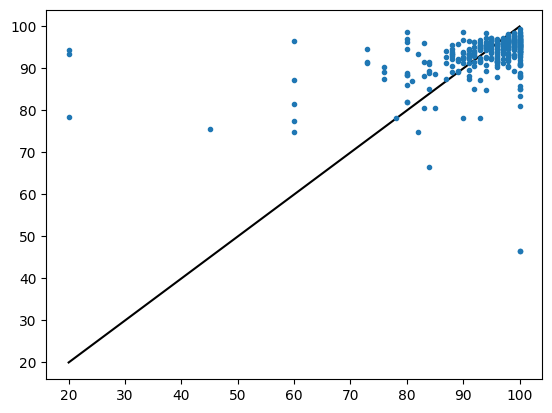

  0%|          | 0/100 [00:00<?, ?it/s]

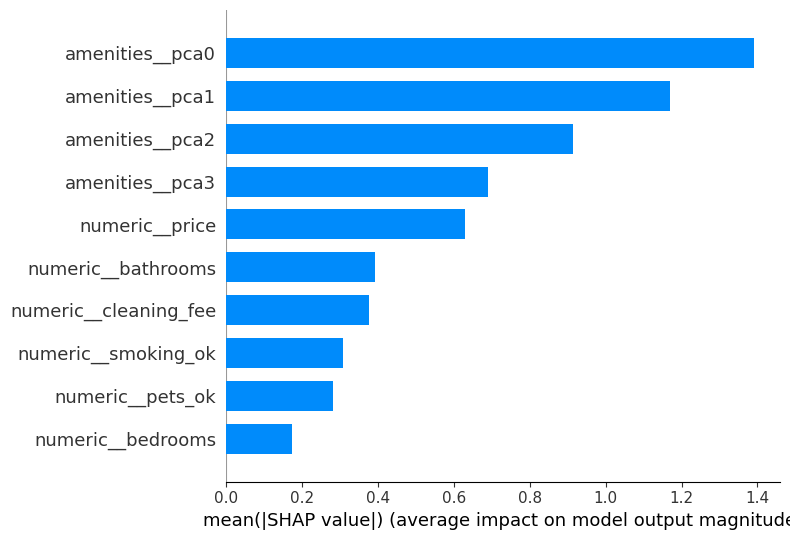

In [13]:
# Random Forest
from sklearn.ensemble import RandomForestRegressor
learner = RandomForestRegressor(random_state=seed)
hyperparameters = {
    'prep__combined__amenities__pca__n_components': [2,4],
    'prep__imputer__n_neighbors': [3,7],
    'learner__max_depth': [3,6,9],
}
model = run_model(learner, hyperparameters)
regessors[model.name] = model
run_shap(model)

Fitting KNeighborsRegressor with hyperparameter grid: {'prep__combined__amenities__pca__n_components': [2, 4], 'prep__imputer__n_neighbors': [3, 7], 'learner__n_neighbors': [3, 6, 9]}
best model: R^2=0.164 with hyperparameters {'learner__n_neighbors': 9, 'prep__combined__amenities__pca__n_components': 4, 'prep__imputer__n_neighbors': 7}


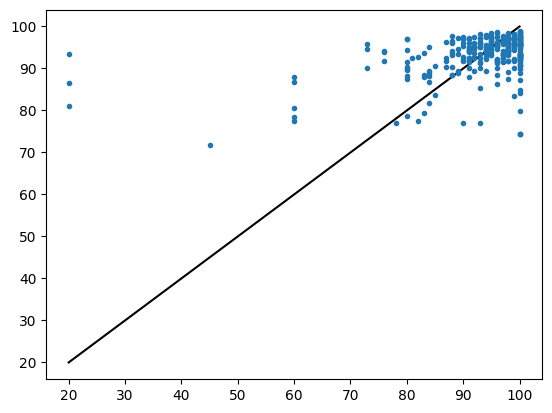

  0%|          | 0/100 [00:00<?, ?it/s]

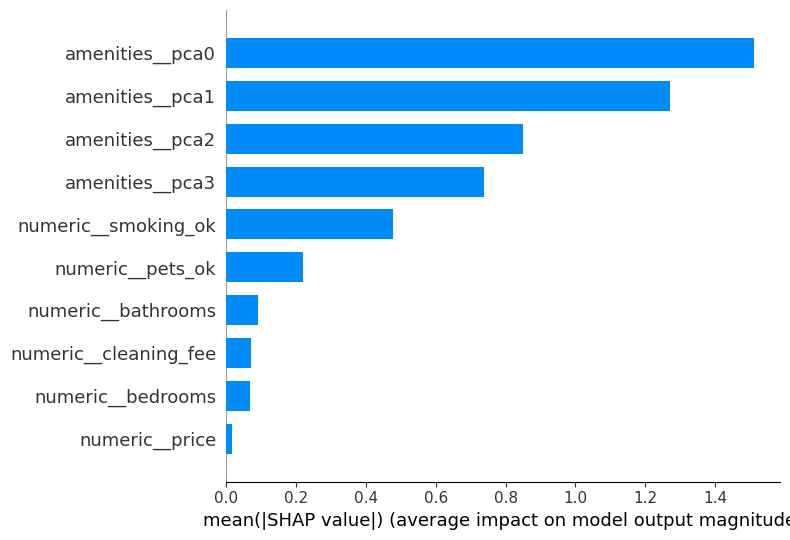

In [14]:
# K-nearest neighbors
from sklearn.neighbors import KNeighborsRegressor
learner = KNeighborsRegressor()
hyperparameters = {
    'prep__combined__amenities__pca__n_components': [2,4],
    'prep__imputer__n_neighbors': [3,7],
    'learner__n_neighbors': [3,6,9],
}
model = run_model(learner, hyperparameters)
regessors[model.name] = model
run_shap(model)

Fitting SVR with hyperparameter grid: {'prep__combined__amenities__pca__n_components': [2, 4], 'prep__imputer__n_neighbors': [3, 7], 'learner__C': array([0.1 , 2.55, 5.  ])}
best model: R^2=0.073 with hyperparameters {'learner__C': 5.0, 'prep__combined__amenities__pca__n_components': 4, 'prep__imputer__n_neighbors': 3}


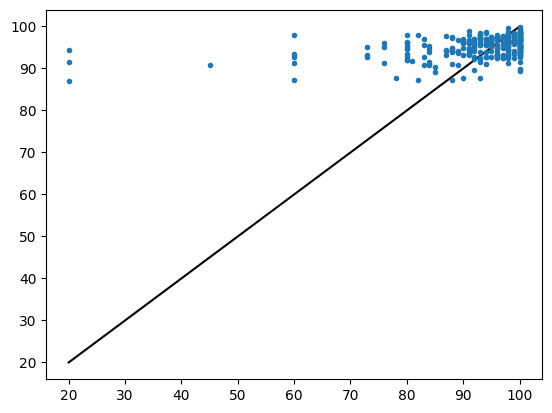

  0%|          | 0/100 [00:00<?, ?it/s]

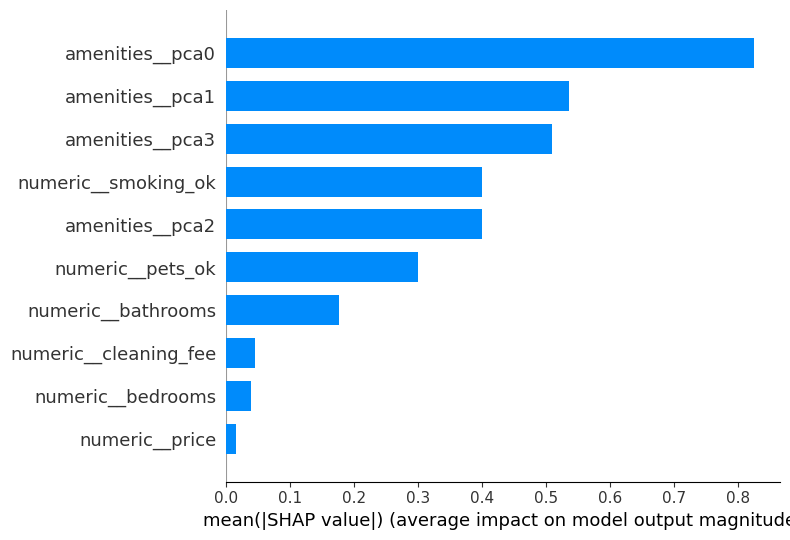

In [15]:
# Support Vector Machines
from sklearn.svm import SVR
learner = SVR()
hyperparameters = {
    'prep__combined__amenities__pca__n_components': [2,4],
    'prep__imputer__n_neighbors': [3,7],
    'learner__C': np.linspace(0.1,5,3),
}
model = run_model(learner, hyperparameters)
regessors[model.name] = model
run_shap(model)

Well, these models suck. R^2 ranges from 0 (terrible) to 1 (perfect). Even our best model is less than 0.2.  So, we want to go back and rethink some choices made along the way. But we built this code so that will probably not require much effort or recoding.

#Classification

Now, let's bin the target and demonstrate a classification task

In [16]:
# In order to make this a classification task, we will use pandas qcut function to bin the target values into n_labels classes with roughly equal frequencies
y = df.loc[mask, target]
n_labels = 2
y_binned = pd.qcut(df.loc[mask, target], q=n_labels, precision=1)
y    = y_binned.cat.codes
bins = y_binned.cat.categories.astype(str).to_list()

# create holdout set to estimate generalization performance after tuning
X_train, X_holdout, y_train, y_holdout = train_test_split(X, y, test_size=0.10, random_state=seed)

# dictionary to store models
classifiers = dict()

# function to make training with different supervised learners convenient
def run_model(learner, hyperparameters):
    # append final learner to pipeline
    estimator = Pipeline(steps = [('prep', prep), ('learner', learner)])
    
    # prepare to tune hyperparameters using either exhaustive grid search or randomized grid search
    model =       GridSearchCV(estimator, hyperparameters, cv=5, scoring='f1_micro')
    # model = RandomizedSearchCV(estimator, hyperparameters, cv=5, scoring='f1_micro')
    
    # give model a name based on its learner
    model.name = str(learner).split('(')[0]

    print(f'Fitting {model.name} with hyperparameter grid:', hyperparameters)
    model.fit(X_train, y_train)

    # Apply best model to holdout set to estimate generalization performance
    model.generalization_score = model.score(X_holdout, y_holdout)
    print(f'best model: F1={model.generalization_score:.3f} with hyperparameters {model.best_params_}')
    print(classification_report(y_holdout, model.predict(X_holdout), target_names=bins))
    
    ConfusionMatrixDisplay.from_estimator(model, X_holdout, y_holdout, display_labels=bins)
    plt.show()
    
    if n_labels == 2:
        RocCurveDisplay.from_estimator(model, X_holdout, y_holdout)
        plt.plot([0,1],[0,1])
        plt.show()

    # save file to google drive folder
    file = path / f'{model.name}.model'
    model.file = file
    joblib.dump(model, file)
    return model

Fitting RandomForestClassifier with hyperparameter grid: {'prep__combined__amenities__pca__n_components': [2, 4], 'prep__imputer__n_neighbors': [3, 7]}
best model: F1=0.641 with hyperparameters {'prep__combined__amenities__pca__n_components': 2, 'prep__imputer__n_neighbors': 3}
               precision    recall  f1-score   support

 (19.9, 96.0]       0.66      0.70      0.68       162
(96.0, 100.0]       0.62      0.58      0.60       139

     accuracy                           0.64       301
    macro avg       0.64      0.64      0.64       301
 weighted avg       0.64      0.64      0.64       301



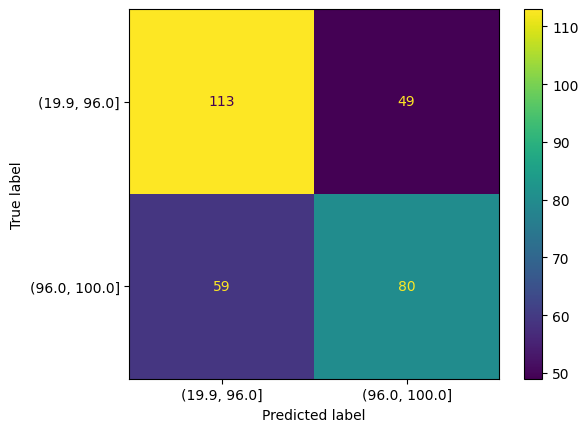

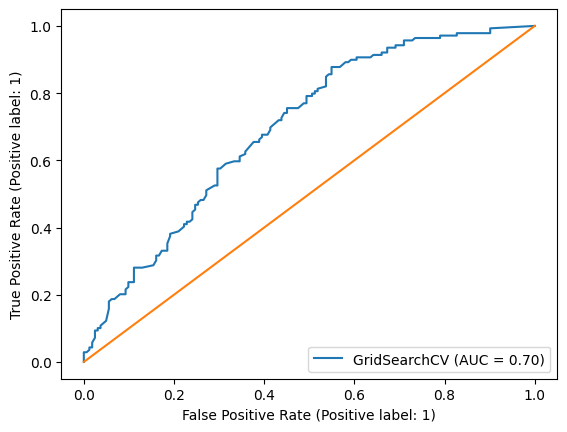

  0%|          | 0/100 [00:00<?, ?it/s]

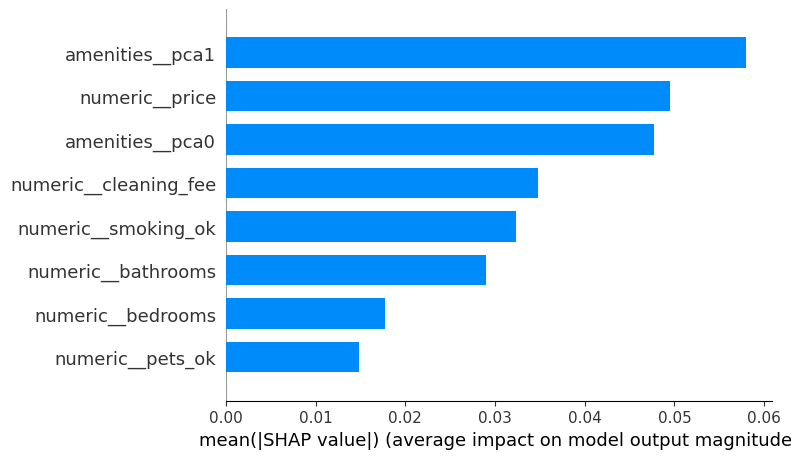

In [17]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier
learner = RandomForestClassifier(random_state=seed)
hyperparameters = {
    'prep__combined__amenities__pca__n_components': [2,4],
    'prep__imputer__n_neighbors': [3,7],
    'learner__max_depth': [3,6,9],
}
model = run_model(learner, hyperparameters)
classifiers[model.name] = model
run_shap(model)

Fitting KNeighborsClassifier with hyperparameter grid: {'prep__combined__amenities__pca__n_components': [2, 4], 'prep__imputer__n_neighbors': [3, 7]}
best model: F1=0.648 with hyperparameters {'prep__combined__amenities__pca__n_components': 4, 'prep__imputer__n_neighbors': 7}
               precision    recall  f1-score   support

 (19.9, 96.0]       0.66      0.72      0.69       162
(96.0, 100.0]       0.63      0.57      0.60       139

     accuracy                           0.65       301
    macro avg       0.65      0.64      0.64       301
 weighted avg       0.65      0.65      0.65       301



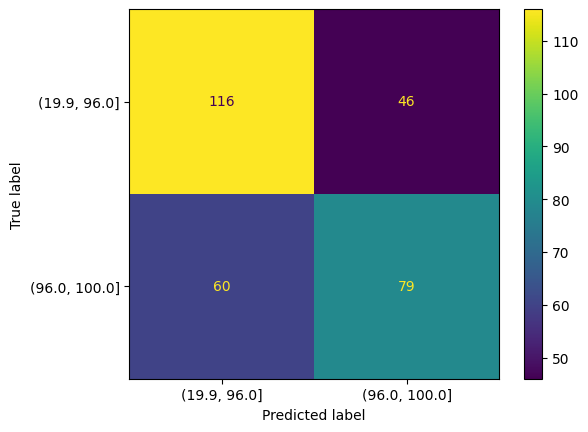

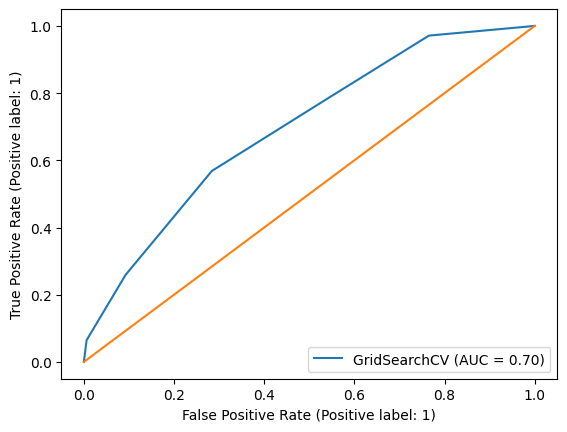

  0%|          | 0/100 [00:00<?, ?it/s]

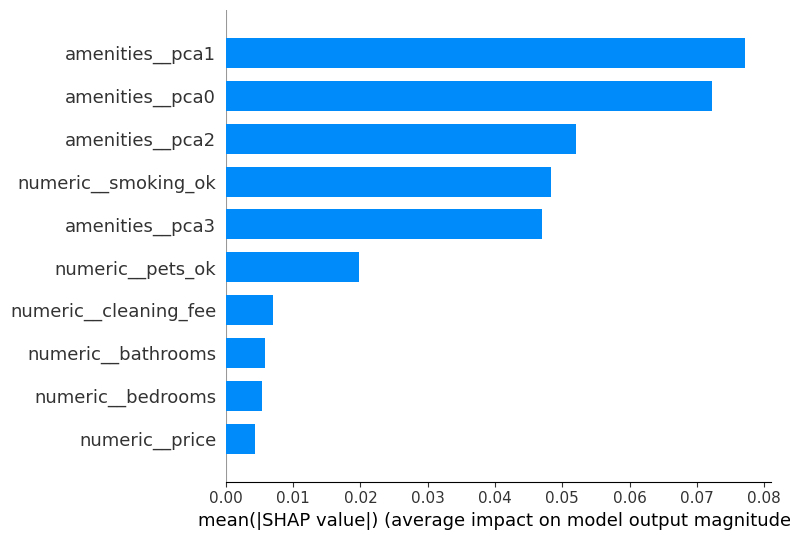

In [18]:
# K-nearest neighbors
from sklearn.neighbors import KNeighborsClassifier
learner = KNeighborsClassifier()
hyperparameters = {
    'prep__combined__amenities__pca__n_components': [2,4],
    'prep__imputer__n_neighbors': [3,7],
    'learner__n_neighbors': [3,6,9],
}
model = run_model(learner, hyperparameters)
classifiers[model.name] = model
run_shap(model)

Fitting SVC with hyperparameter grid: {'prep__combined__amenities__pca__n_components': [2, 4], 'prep__imputer__n_neighbors': [3, 7], 'learner__C': array([0.1 , 2.55, 5.  ])}
best model: F1=0.618 with hyperparameters {'learner__C': 5.0, 'prep__combined__amenities__pca__n_components': 4, 'prep__imputer__n_neighbors': 3}
               precision    recall  f1-score   support

 (19.9, 96.0]       0.62      0.73      0.67       162
(96.0, 100.0]       0.61      0.48      0.54       139

     accuracy                           0.62       301
    macro avg       0.62      0.61      0.61       301
 weighted avg       0.62      0.62      0.61       301



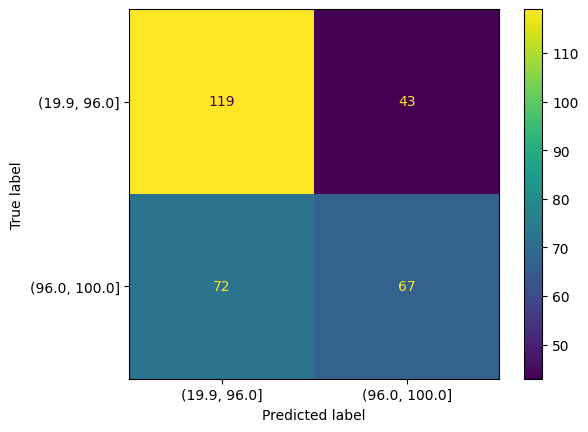

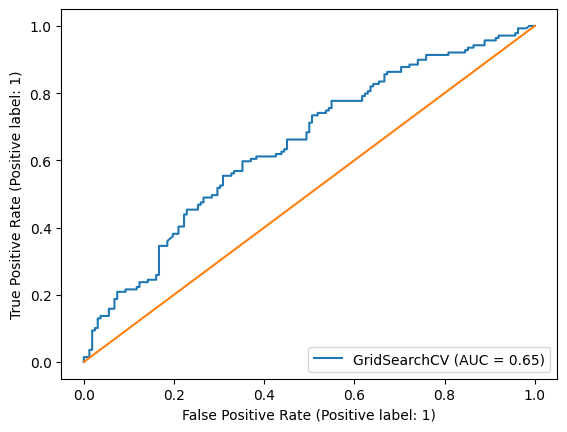

  0%|          | 0/100 [00:00<?, ?it/s]

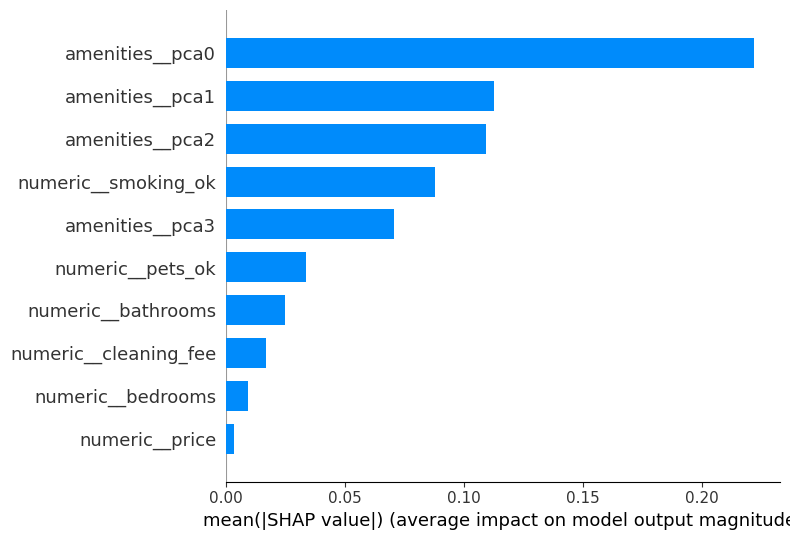

In [19]:
# Support Vector Machines
from sklearn.svm import SVC
learner = SVC()
hyperparameters = {
    'prep__combined__amenities__pca__n_components': [2,4],
    'prep__imputer__n_neighbors': [3,7],
    'learner__C': np.linspace(0.1,5,3),
}
model = run_model(learner, hyperparameters)
classifiers[model.name] = model
run_shap(model)